# 🎡 ARIMA and SARIMA: Real-World Time Series Forecasting

Временные ряды и прогнозирование являются одними из ключевых проблем в статистике и **Data Science**. Данные становятся временными рядами, когда они отбираются по атрибутам, ограниченным во времени, таким как дни, месяцы и годы, что по своей сути придает им неявный порядок. Прогнозирование - это когда мы берем эти данные и предсказываем будущие значения.

**ARIMA и SARIMA** - оба алгоритма прогнозирования. **ARIMA** учитывает прошлые значения (авторегрессия, скользящее среднее) и на их основе прогнозирует будущие значения. **SARIMA** аналогичным образом использует прошлые значения, но при этом учитывает любые сезонные особенности. Поскольку SARIMA учитывает сезонность в качестве параметра, она значительно эффективнее ARIMA при прогнозировании сложных пространств данных, содержащих циклы.

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sidetable
import warnings
warnings.filterwarnings('error')
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from datetime import datetime, timedelta

from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.tsa.arima_model import ARIMA # DEPRICATED
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from time import time

RANDOM_SEED = np.random.seed(22)
DATASET = Path.cwd() / "data"

#  dickey-fuller test
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')


## ETL

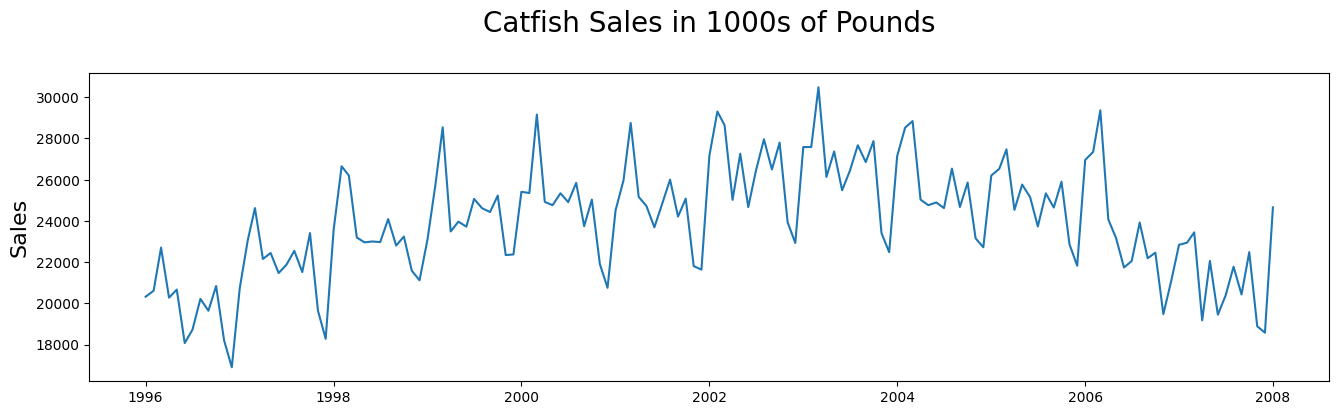

In [9]:
# read data
catfish_sales = pd.read_csv(f'{DATASET}/catfish.csv',
                            date_format='%Y-%m-%d',
                            parse_dates=[0],
                            index_col=0)
# infer the frequency of the data
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

# transform
start_date = datetime(1996,1,1)
end_date = datetime(2008,1,1)
lim_catfish_sales = catfish_sales[start_date:end_date]

catfish_sales.stb.missing()

# plot
plt.figure(figsize=(16,4))
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20, pad=30) # продажи сомов в тысячах фунтов
plt.ylabel('Sales', fontsize=16)
plt.plot(lim_catfish_sales);

In [10]:
catfish_sales.stb.missing()

,missing,total,percent
Total,0,324,0.0


> в данных присутствует определенный тренд и сезонность. Для лучшего понимания проведем STL-разложение. А так же отсутствуют пропуски

## STL decomposition

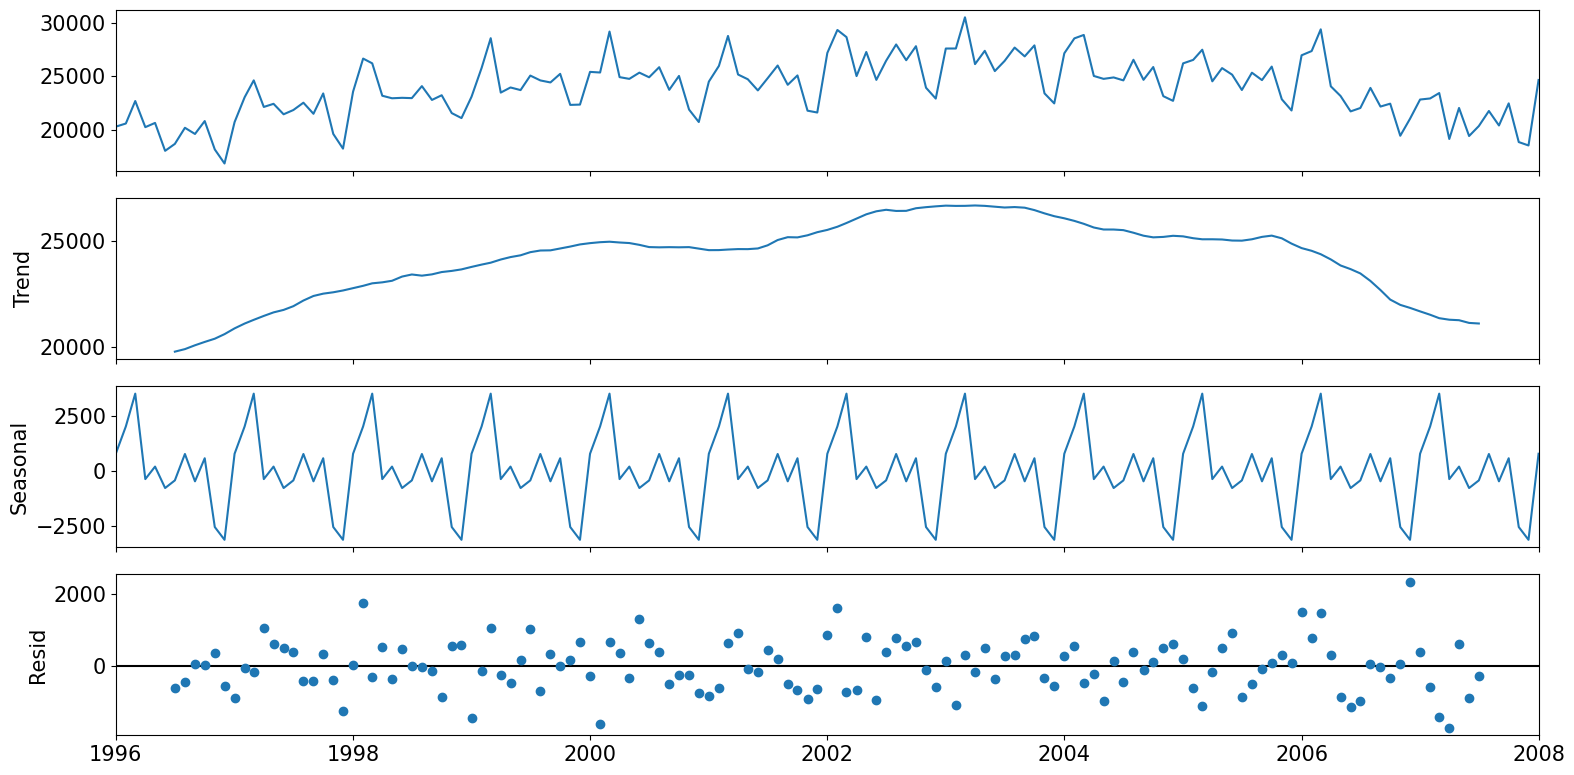

In [11]:
plt.rc('figure', figsize=(16, 8))
plt.rc('font', size=15)

result = seasonal_decompose(lim_catfish_sales,model='additive')
fig = result.plot();

* Наблюдается 6-месячная и 12-месячная сезонная динамика
* Очевиден восходящий и нисходящий тренд
* Рассмотрим графики **ACF и PACF**, чтобы получить представление о значениях p и q

## ACF and PACF plots

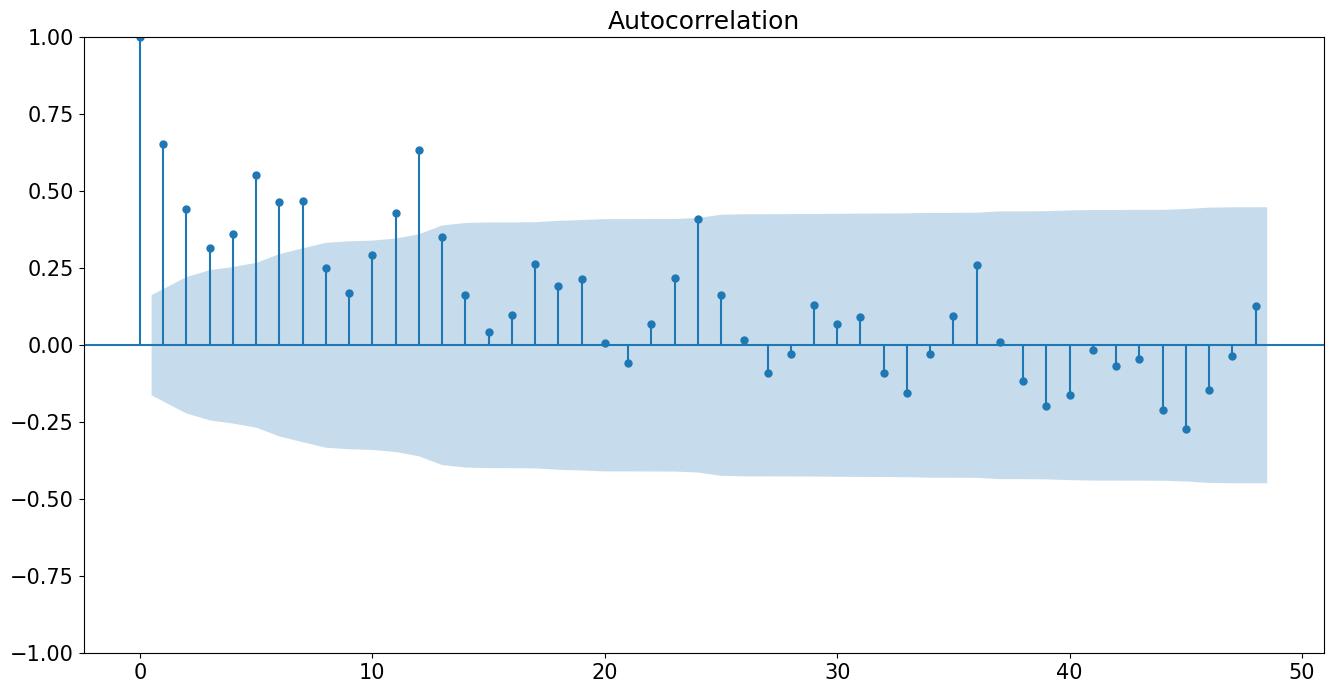

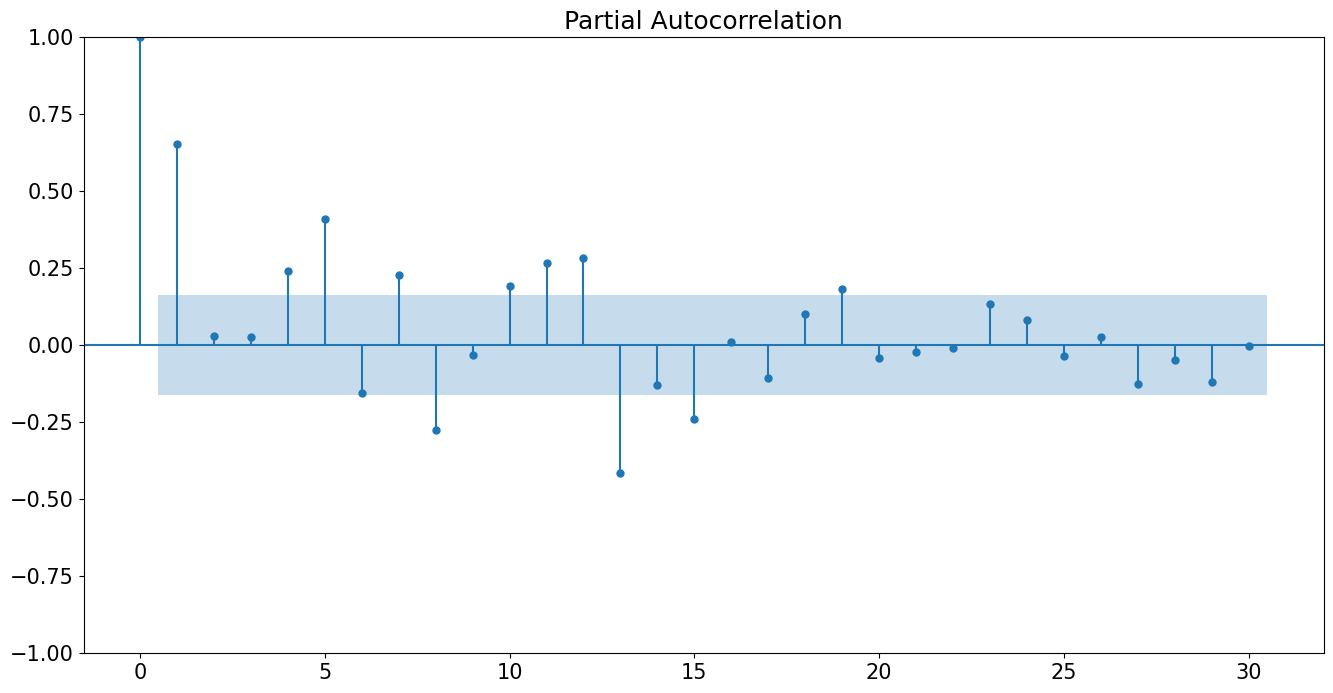

In [12]:
plot_acf(lim_catfish_sales['Total'], lags=48);
plot_pacf(lim_catfish_sales['Total'], lags=30);

* В 6-месячном и 12-месячном периодах наблюдается значительный всплеск ACF
* PACF имеет почти синусоидальную форму
* Коэффициент дифференцирования d следует оставить равным 1, так как имеется явный тренд и нестационарные данные. P может быть проверен при значениях 6 и 12.

## Fitting ARIMA

>Для реализации и использования ARIMA мы будем использовать модуль statsmodels. Для этого мы импортировали класс ARIMA из statsmodels. Теперь выполним подгонку с параметрами, которые мы обсуждали в предыдущем разделе.

In [13]:
arima = sm.tsa.arima.ARIMA(lim_catfish_sales['Total'], order=(12, 6, 1))
predictions = arima.fit().predict()

> я начал с (12,6,1) для (p,d,q), исходя из того, что было на графиках ACF и PACF. 

>Посмотрим, как наши прогнозы согласуются с исходными данными.

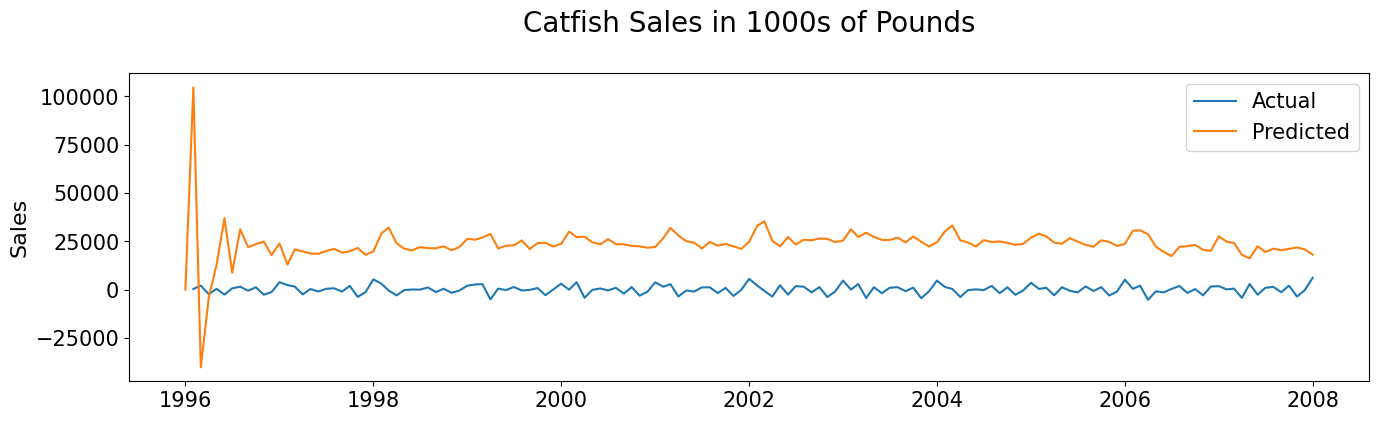

In [14]:
plt.figure(figsize=(16, 4))
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20, pad=30)
plt.ylabel('Sales', fontsize=16)

plt.plot(lim_catfish_sales.diff(), label="Actual");
plt.plot(predictions, label="Predicted");
plt.legend()

Здесь видно, что модель отразила суть данных, но склонна к завышению значений. Мы можем поэкспериментировать с большим количеством значений p,d,q, чтобы лучше обобщить модель.

Испытания и оптимизация - это один из способов, но можно также использовать Auto-ARIMA. По сути, она делает всю работу за вас и настраивает гиперпараметры за вас. 


## SARIMA

SARIMA расшифровывается как Seasonal-ARIMA и включает в себя вклад сезонности в прогноз. Важность сезонности вполне очевидна, и ARIMA не может отразить эту информацию в неявном виде.

In [15]:
sarima = SARIMAX(lim_catfish_sales['Total'],
                order=(1,1,1),
                seasonal_order=(1,1,0,12))
predictions = sarima.fit().predict()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82528D+00    |proj g|=  2.22856D-01

At iterate    5    f=  7.73485D+00    |proj g|=  5.30062D-02

At iterate   10    f=  7.67575D+00    |proj g|=  2.64818D-02

At iterate   15    f=  7.67492D+00    |proj g|=  6.63131D-04

At iterate   20    f=  7.67472D+00    |proj g|=  1.52586D-02

At iterate   25    f=  7.65970D+00    |proj g|=  1.07335D-01

At iterate   30    f=  7.65017D+00    |proj g|=  3.40023D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

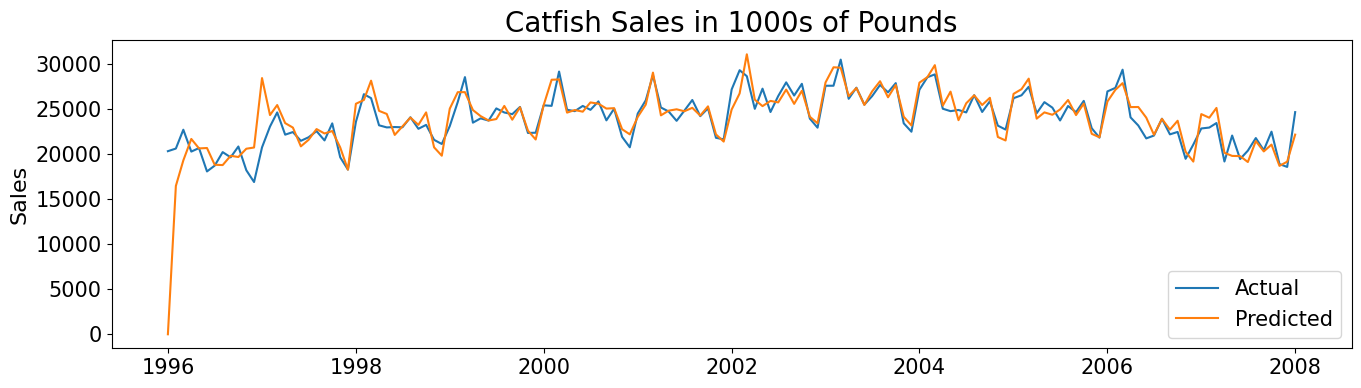

In [16]:
plt.figure(figsize=(16,4))
plt.plot(lim_catfish_sales, label="Actual")
plt.plot(predictions, label="Predicted")
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.legend()

> Как видно, вначале модель с трудом поддавалась подгонке, вероятно, из-за не совсем корректной инициализации, но затем она быстро вышла на правильный путь. По сравнению с моделью ARIMA, результат довольно хороший, что говорит о том, что SARIMA лучше учитывает сезонность, и если она присутствует в данных, то имеет смысл опробовать SARIMA.

## References

<ol>
<li><a href="https://neptune.ai/blog/time-series-prediction-vs-machine-learning" target="_blank">https://neptune.ai/blog/time-series-prediction-vs-machine-learning</a></li>



<li><a href="https://otexts.com/fpp2/arima.html" target="_blank" rel="noreferrer noopener nofollow">https://otexts.com/fpp2/arima.html</a></li>



<li><a href="https://towardsdatascience.com/understanding-arima-time-series-modeling-d99cd11be3f8" target="_blank" rel="noreferrer noopener nofollow">https://towardsdatascience.com/understanding-arima-time-series-modeling-d99cd11be3f8</a></li>



<li><a href="https://towardsdatascience.com/understanding-sarima-955fe217bc77" target="_blank" rel="noreferrer noopener nofollow">https://towardsdatascience.com/understanding-sarima-955fe217bc77</a></li>



<li><a href="/blog/anomaly-detection-in-time-series">https://neptune.ai/blog/anomaly-detection-in-time-series</a></li>



<li><a href="https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html" target="_blank" rel="noreferrer noopener nofollow">https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html</a></li>



<li><a href="https://otexts.com/fpp2/seasonal-arima.html" target="_blank" rel="noreferrer noopener nofollow">https://otexts.com/fpp2/seasonal-arima.html</a></li>



<li><a href="https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd" target="_blank" rel="noreferrer noopener nofollow">https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd</a></li>



<li><a href="https://towardsdatascience.com/time-series-from-scratch-autocorrelation-and-partial-autocorrelation-explained-1dd641e3076f" target="_blank" rel="noreferrer noopener nofollow">https://towardsdatascience.com/time-series-from-scratch-autocorrelation-and-partial-autocorrelation-explained-1dd641e3076f</a></li>



<li><a href="https://eng.uber.com/forecasting-introduction/" target="_blank" rel="noreferrer noopener nofollow">https://eng.uber.com/forecasting-introduction/</a></li>



<li><a href="https://www.capitalone.com/tech/machine-learning/understanding-arima-models/" target="_blank" rel="noreferrer noopener nofollow">https://www.capitalone.com/tech/machine-learning/understanding-arima-models/</a></li>



<li><a href="https://medium.com/analytics-vidhya/why-you-should-not-use-arima-to-forecast-demand-196cc8b8df3d" target="_blank" rel="noreferrer noopener nofollow">https://medium.com/analytics-vidhya/why-you-should-not-use-arima-to-forecast-demand-196cc8b8df3d</a></li>
</ol><hr>mand-1<br>96cc8b8df3d